<a href="https://colab.research.google.com/github/RealMyeong/Aiffel_Exploration/blob/main/16_Pix2Pix/EX_BS2_project16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16. 프로젝트 : Segmentation map으로 도로 이미지 만들기


In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.6
2.8.2


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

- 각각의 이미지들이 어떻게 생겼는지 확인

In [3]:
import os

data_path = '/content/drive/MyDrive/AIFFEL/EX/16.채색/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


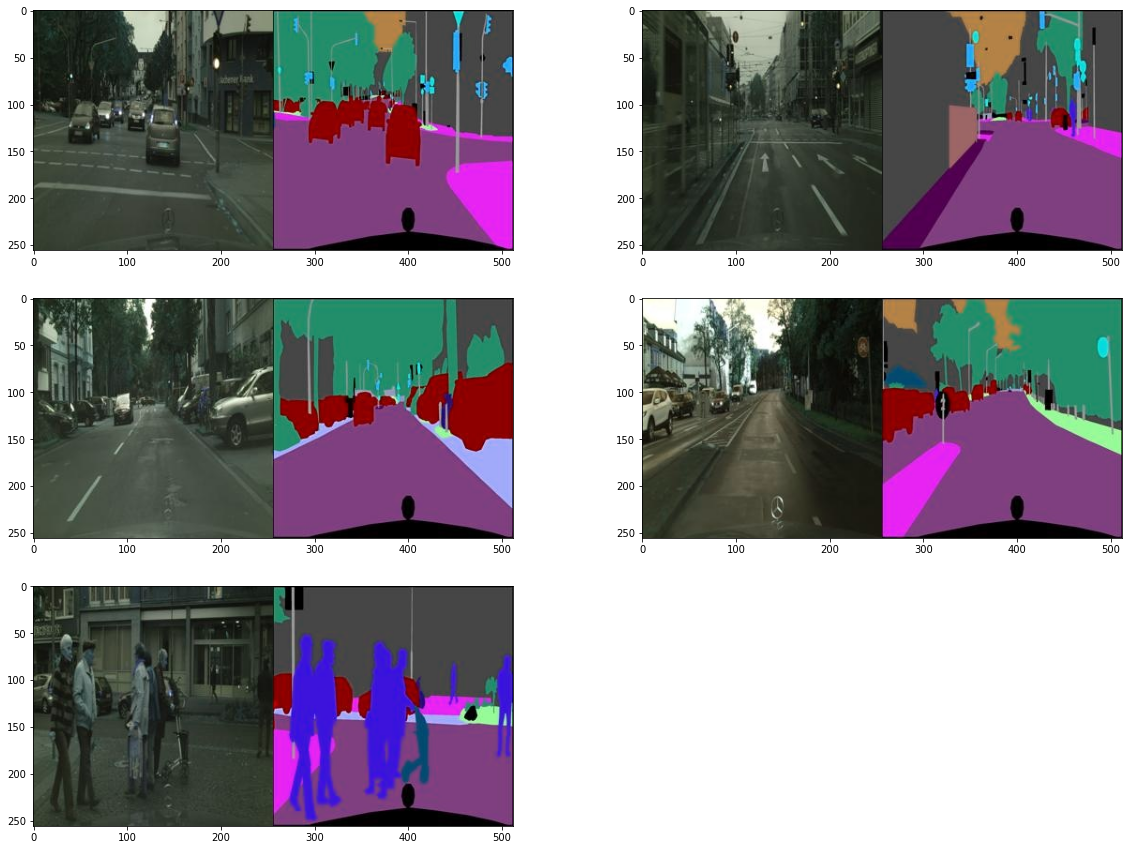

In [4]:
plt.figure(figsize=(20,15))
for i in range(1,6):
  f = data_path + os.listdir(data_path)[np.random.randint(1000)]
  img = cv2.imread(f, cv2.IMREAD_COLOR)
  plt.subplot(3,2,i)
  plt.imshow(img)

In [5]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256,256,3) 두 개로 나누면 될 것 같음.


In [6]:
# pixel 값을 -1~1로 정규화 해주는 함수
def normalize(x):
  x = tf.cast(x, tf.float32)
  return (x/127.5) - 1

# pixel 값을 다시 원래대로 되돌리는 함수
def denormalize(x):
  x = (x+1) * 127.5
  x = x.numpy()
  return x.astype(np.uint8)


# 이미지 불러오는 함수
def load_img(img_path):
  image = tf.io.read_file(img_path)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1] // 2
  real_img = image[:, :w, :]
  input_img = image[:, w:, :]

  real_img = tf.cast(real_img, tf.float32)
  input_img = tf.cast(input_img, tf.float32)

  return normalize(input_img), normalize(real_img) 

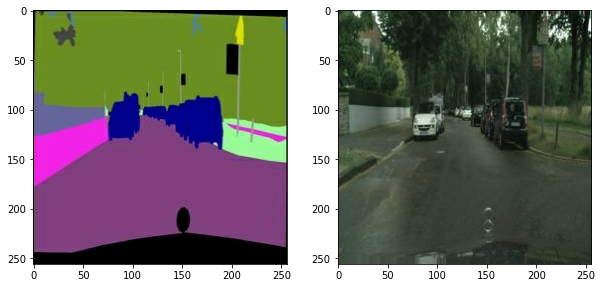

In [7]:
input_img, real_img = load_img(data_path + '252.jpg')

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_img))
plt.subplot(1,2,2); plt.imshow(denormalize(real_img))

- augmentation기법 적용

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(input_img, real_img):
  stacked = tf.concat([input_img, real_img], axis=-1)

  _pad = tf.constant([[30,30],[30,30],[0,0]])
  if tf.random.uniform(()) < .5:
    padded = tf.pad(stacked, _pad, 'REFLECT')
  else:
    padded = tf.pad(stacked, _pad, 'CONSTANT', constant_values=1.)

  out = image.random_crop(padded, size=[256,256,6])

  out = image.random_flip_left_right(out)
  out = image.random_flip_up_down(out)
  out = image.random_brightness(out, 0.2) # augmentation 추가
  out = image.random_contrast(out, 0.2, 0.5)


  if tf.random.uniform(()) < .5:
    degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    out = image.rot90(out, k=degree)
  
  return out[...,:3], out[...,3:]

- reflect padding

```
>>> m = nn.ReflectionPad2d(2)
>>> input = torch.arange(9, dtype=torch.float).reshape(1, 1, 3, 3)
>>> input
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
>>> m(input)
tensor([[[[8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.],
          [5., 4., 3., 4., 5., 4., 3.],
          [8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.]]]])
          
```

- constant padding

```
>>> m = nn.ConstantPad2d(2, 3.5)
>>> input = torch.randn(1, 2, 2)
>>> input
tensor([[[ 1.6585,  0.4320],
         [-0.8701, -0.4649]]])
>>> m(input)
tensor([[[ 3.5000,  3.5000,  3.5000,  3.5000,  3.5000,  3.5000],
         [ 3.5000,  3.5000,  3.5000,  3.5000,  3.5000,  3.5000],
         [ 3.5000,  3.5000,  1.6585,  0.4320,  3.5000,  3.5000],
         [ 3.5000,  3.5000, -0.8701, -0.4649,  3.5000,  3.5000],
         [ 3.5000,  3.5000,  3.5000,  3.5000,  3.5000,  3.5000],
         [ 3.5000,  3.5000,  3.5000,  3.5000,  3.5000,  3.5000]]])
```

- augmentation 된 이미지들 한 번 출력해봄

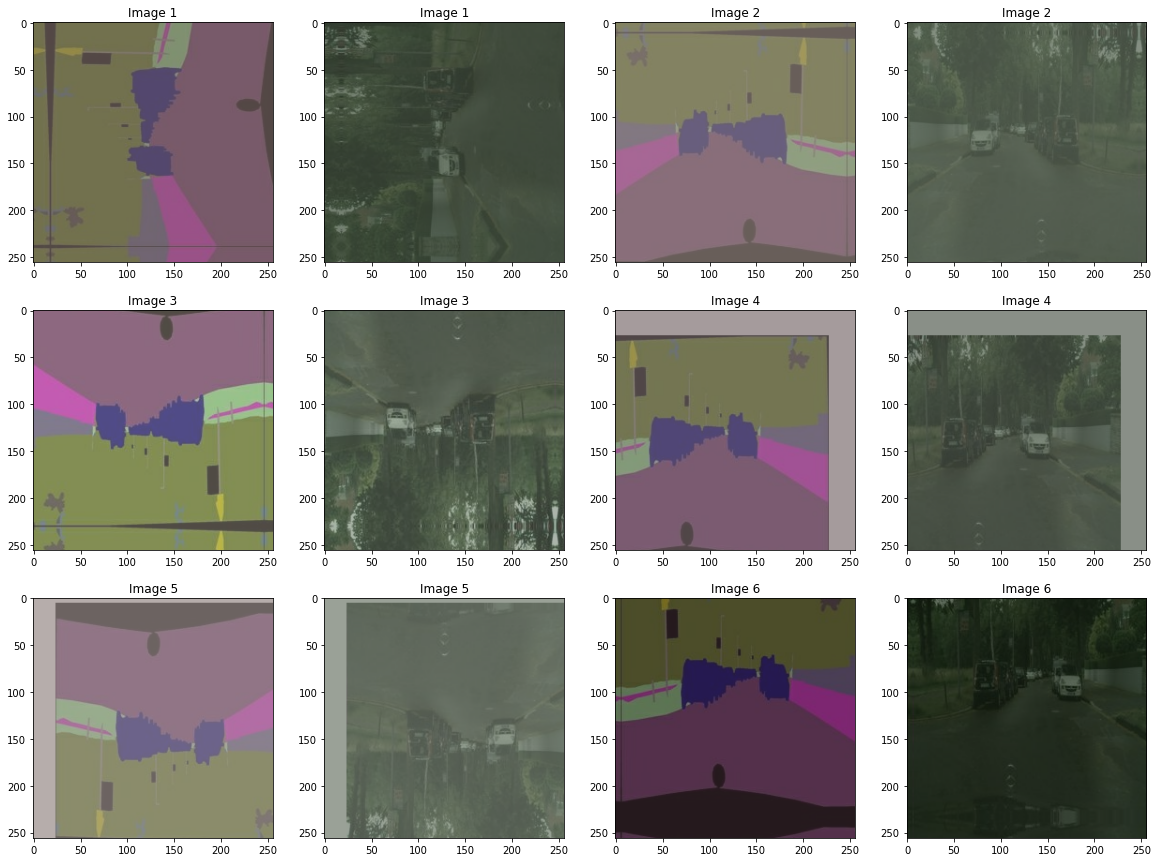

In [9]:
plt.figure(figsize=(20,15))
img_n = 1
for i in range(1, 13, 2):
  augmented_input, augmented_real = apply_augmentation(input_img, real_img)

  plt.subplot(3, 4, i)
  plt.imshow(denormalize(augmented_input))
  plt.title(f'Image {img_n}')
  plt.subplot(3, 4, i+1)
  plt.imshow(denormalize(augmented_real))
  plt.title(f'Image {img_n}')
  img_n += 1


- 학습 데이터에 적용

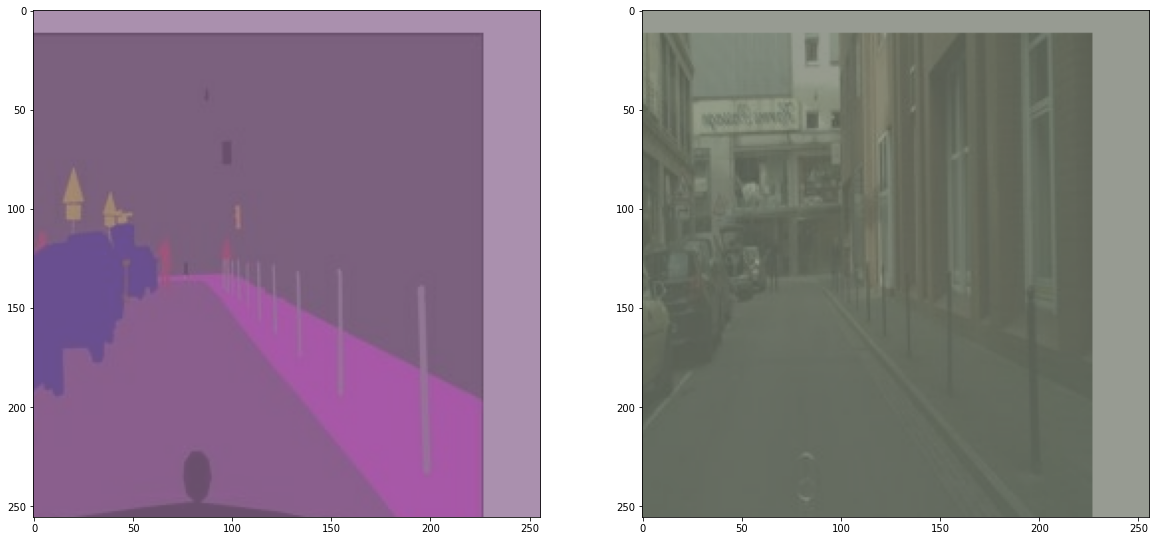

In [10]:
from tensorflow import data

def get_train(img_path):
  input, real = load_img(img_path)
  input, real = apply_augmentation(input, real)
  return input, real

train_img = data.Dataset.list_files(data_path + '*.jpg')
train_img = train_img.map(get_train).shuffle(100).batch(4)

sample = train_img.take(1)
sample = list(sample.as_numpy_iterator())
input, real = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(input[0].astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(real[0].astype(np.uint8))

Generator 구현
---

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
  def __init__(self, n_filters, use_bn=True):
    super(EncodeBlock, self).__init__()
    self.use_bn = use_bn
    self.conv = layers.Conv2D(n_filters, 4, 2, 'same', use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.lrelu = layers.LeakyReLU(0.2)

  def call(self, x):
    x = self.conv(x)
    if self.use_bn:
      x = self.batchnorm(x)
    return self.lrelu(x)

n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정할 수 있습니다.

이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했습니다.

Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있습니다.

In [12]:
class Encoder(layers.Layer):
  def __init__(self):
    super(Encoder, self).__init__()
    filters = [64, 128, 256, 512, 512, 512, 512, 512]

    self.blocks=[]
    for i, f in enumerate(filters):
      if i == 0:
        self.blocks.append(EncodeBlock(f, use_bn=False))
      else:
        self.blocks.append(EncodeBlock(f))
  
  def call(self, x):
    for block in self.blocks:
      x = block(x)
    return x
  
  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

In [13]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

- decoderblock 구현

In [14]:
class DecoderBlock(layers.Layer):
  def __init__(self, f, dropout=True):
    super(DecoderBlock, self).__init__()
    self.dropout = dropout
    self.Transconv = layers.Conv2DTranspose(f, 4, 2, 'same', use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.relu = layers.ReLU()

  def call(self, x):
    x = self.Transconv(x)
    x = self.batchnorm(x)
    if self.dropout:
      x = layers.Dropout(.5)(x)
    return self.relu(x)

class Decoder(layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    filters = [512, 512, 512, 512, 256, 128, 64]

    self.blocks= []
    for i, f in enumerate(filters):
      if i < 3:
        self.blocks.append(DecoderBlock(f))
      else:
        self.blocks.append(DecoderBlock(f, dropout=False))
      
    self.blocks.append(layers.Conv2DTranspose(3, 4, 2, 'same', use_bias=False))
  
  def call(self, x):
    for block in self.blocks:
      x = block(x)
    return x
  
  def get_summary(self, input_shape=(1,1,512)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

In [15]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decoder_block (DecoderBlock  (None, 2, 2, 512)        4196352   
 )                                                               
                                                                 
 decoder_block_1 (DecoderBlo  (None, 4, 4, 512)        4196352   
 ck)                                                             
                                                                 
 decoder_block_2 (DecoderBlo  (None, 8, 8, 512)        4196352   
 ck)                                                             
                                                                 
 decoder_block_3 (DecoderBlo  (None, 16, 16, 512)      4196352   
 ck)                                                       

In [16]:
class UNetGenerator(Model):
  def __init__(self):
    super(UNetGenerator, self).__init__()
    encoder_filters = [64, 128, 256, 512, 512, 512, 512, 512]
    decoder_filters = [512, 512, 512, 512, 256, 128, 64]

    self.encode_blocks = []
    for i, f in enumerate(encoder_filters):
      if i == 0:
        self.encode_blocks.append(EncodeBlock(f, use_bn=False))
      else:
        self.encode_blocks.append(EncodeBlock(f))
    
    self.decode_blocks = []
    for i, f in enumerate(decoder_filters):
      if i < 3:
        self.decode_blocks.append(DecoderBlock(f))
      else:
        self.decode_blocks.append(DecoderBlock(f, dropout=False))
    
    self.last_conv = layers.Conv2DTranspose(3, 4, 2, 'same', use_bias=False)
  
  def call(self, x):
    features = []
    for block in self.encode_blocks:
      x = block(x)
      features.append(x)

    features = features[:-1]

    for block, feat in zip(self.decode_blocks, features[::-1]):
      x = block(x)
      x = layers.Concatenate()([x,feat])
    
    x = self.last_conv(x)
    return x
  
  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

- 위 코드의 call() 내에서 features = features[:-1] 는 왜 필요할까요?

---
Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.


- 위 코드의 call() 내의 Decoder 연산 부분에서 features[::-1] 는 왜 필요할까요?

---
Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다(맨 위 U-Net 구조 사진 참고). features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.


In [17]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_8 (EncodeBlock)   (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_9 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block_8[0][0]']         
                                                                                            

Discriminator 구성하기
---

- Discblock 구성

In [18]:
class DiscBlock(layers.Layer):
  def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
    super(DiscBlock, self).__init__()
    self.custom_pad = custom_pad
    self.use_bn = use_bn
    self.act = act

    if custom_pad:
      self.padding = layers.ZeroPadding2D()
      self.conv = layers.Conv2D(n_filters, 4, stride, 'valid', use_bias=False) # padding='valid' -> no padding
    else:
      self.conv = layers.Conv2D(n_filters, 4, stride, 'same', use_bias=False) # padding='same' -> zeropadding
    
    self.batchnorm = layers.BatchNormalization()
    self.lrelu = layers.LeakyReLU(0.2) if act else None

  def call(self, x):
    if self.custom_pad:
      x = self.padding(x)
      x = self.conv(x)
    else:
      x = self.conv(x)

    if self.use_bn:
      x = self.batchnorm(x)
    
    if self.act:
      x = self.lrelu(x)
    return x

- Discriminator 구성

In [19]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.block1 = layers.Concatenate()
    self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
    self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
    self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
    self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
    self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
    self.sigmoid = layers.Activation('sigmoid')

    # filters = [64,128,256,512,1]
    # self.blocks = [layers.Concatenate()]
    # for i, f in enumerate(filters):
    #     self.blocks.append(DiscBlock(
    #         n_filters=f,
    #         strides=2 if i<3 else 1,
    #         custom_pad=False if i<3 else True,
    #         use_bn=False if i==0 and i==4 else True,
    #         act=True if i<4 else False
    #     ))    

  def call(self, x, y):
    out = self.block1([x,y])
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = self.block6(out)
    return self.sigmoid(out)

  def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
    x, y = Input(x_shape), Input(y_shape)
    return Model((x,y), self.call(x,y)).summary()

In [20]:
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

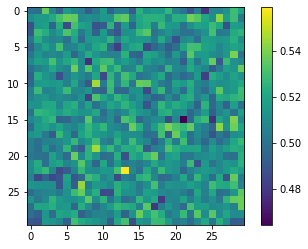

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

학습 및 테스트
---

- 손실 함수 정의

In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
  l1_loss = mae(real_output, fake_output)
  gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
  return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
  return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)
  

- Optimizer

In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [24]:
@tf.function
def train_step(input_img, real_img):
  with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
    # Generator 예측
    fake_color = generator(input_img, training=True)
    # Discriminator 예측
    fake_disc = discriminator(input_img, fake_color, training=True)
    real_disc = discriminator(input_img, real_img, training=True)
    # Generator 손실 계산
    gene_loss, l1_loss = get_gene_loss(fake_color, real_img, fake_disc)
    gene_total_loss = gene_loss + ( 100 * l1_loss) ## <==== L1 손실 반영 λ=100
    # Discriminator 손실 계산
    disc_loss = get_disc_loss(fake_disc, real_disc)

  gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
  disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
  disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
  return gene_loss, l1_loss, disc_loss

전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않습니다.  
다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인하셨나요? (## 이 표시가 있는 부분을 확인해 주세요.) 논문에서는 Generator의 손실을 아래와 같이 정의했습니다.

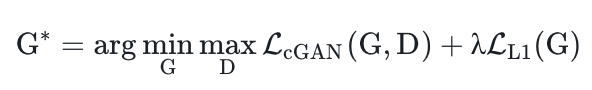

위 식에서 λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용했습니다.

앞서 정의한 함수를 이용해서 학습을 진행합니다. 우선 10 epoch 학습해 봅시다.

In [25]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

# 그래프를 그리기 위해 loss들의 리스트를 만들고 결과 출력 마다 loss값을 추가해서 기록

g_loss_list = []
d_loss_list = []
l1_loss_list = []
for epoch in range(1, EPOCHS+1):
  for i, (input, real) in enumerate(train_img):
    g_loss, l1_loss, d_loss = train_step(input, real)
    # 100회 반복마다 손실을 출력
    if (i+1) % 100 == 0:
      print(f'EPOCH[{epoch}] - STEP[{i+1}] \n Generator_loss:{g_loss.numpy():.4f} \n L1_loss:{l1_loss.numpy():.4f} \n Discriminator_loss:{d_loss.numpy():.4f}', end='\n\n')

    g_loss_list.append(g_loss.numpy())
    d_loss_list.append(d_loss.numpy())
    l1_loss_list.append(l1_loss.numpy())    

EPOCH[1] - STEP[100] 
 Generator_loss:1.0667 
 L1_loss:0.1274 
 Discriminator_loss:0.9863

EPOCH[1] - STEP[200] 
 Generator_loss:1.3492 
 L1_loss:0.1330 
 Discriminator_loss:0.7952

EPOCH[2] - STEP[100] 
 Generator_loss:1.2561 
 L1_loss:0.0929 
 Discriminator_loss:1.8419

EPOCH[2] - STEP[200] 
 Generator_loss:2.3979 
 L1_loss:0.0915 
 Discriminator_loss:1.2242

EPOCH[3] - STEP[100] 
 Generator_loss:1.2230 
 L1_loss:0.1229 
 Discriminator_loss:0.5783

EPOCH[3] - STEP[200] 
 Generator_loss:1.1737 
 L1_loss:0.1043 
 Discriminator_loss:1.7094

EPOCH[4] - STEP[100] 
 Generator_loss:1.9855 
 L1_loss:0.1287 
 Discriminator_loss:0.5284

EPOCH[4] - STEP[200] 
 Generator_loss:1.5044 
 L1_loss:0.1128 
 Discriminator_loss:0.5531

EPOCH[5] - STEP[100] 
 Generator_loss:0.6438 
 L1_loss:0.1233 
 Discriminator_loss:1.1284

EPOCH[5] - STEP[200] 
 Generator_loss:1.0821 
 L1_loss:0.1051 
 Discriminator_loss:0.7648

EPOCH[6] - STEP[100] 
 Generator_loss:1.5489 
 L1_loss:0.0996 
 Discriminator_loss:0.6774


결과 이미지 뽑아서 비교
---

- 첫 시도

Epochs : 50  
Augmentation 추가 : 
out = image.random_brightness(out, 0.2)

- 두 번째 시도

Epochs : 100  
Augmentation 추가 : out = image.random_contrast(out, 0.2, 0.5)

- 세 번째 시도

두 번째와 바뀐 건 없음
결과 시각화 부분에서 실수가 있어서 다시 해봄

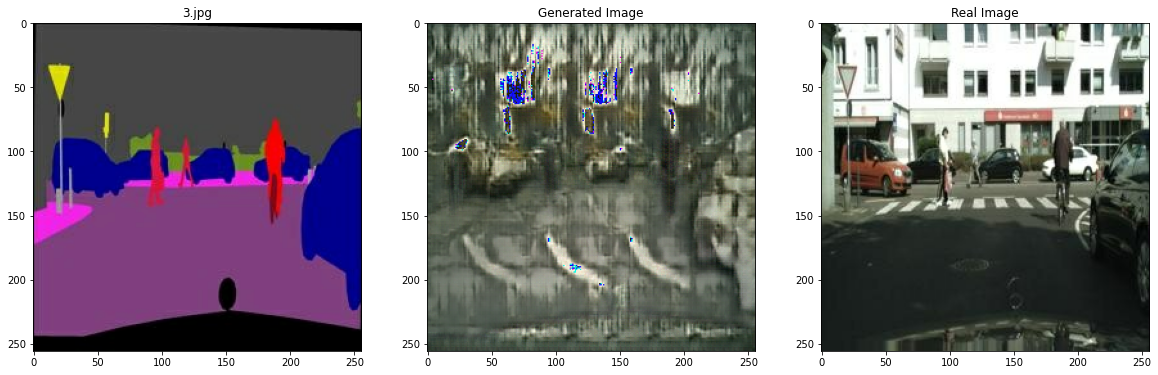

In [26]:
test_ind = 1
test_data_path = '/content/drive/MyDrive/AIFFEL/EX/16.채색/cityscapes/val/'
f = test_data_path + os.listdir(test_data_path)[test_ind]
input_img, real_img = load_img(f)

pred = generator(tf.expand_dims(input_img, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title(f'{os.listdir(test_data_path)[test_ind]}')
plt.imshow(denormalize(input_img))
plt.subplot(1,3,2)
plt.title('Generated Image')
plt.imshow(pred[0])
plt.subplot(1,3,3)
plt.title('Real Image')
plt.imshow(denormalize(real_img))
plt.savefig('/content/drive/MyDrive/AIFFEL/EX/16.채색/results_img/third_result.jpeg', format='jpeg')

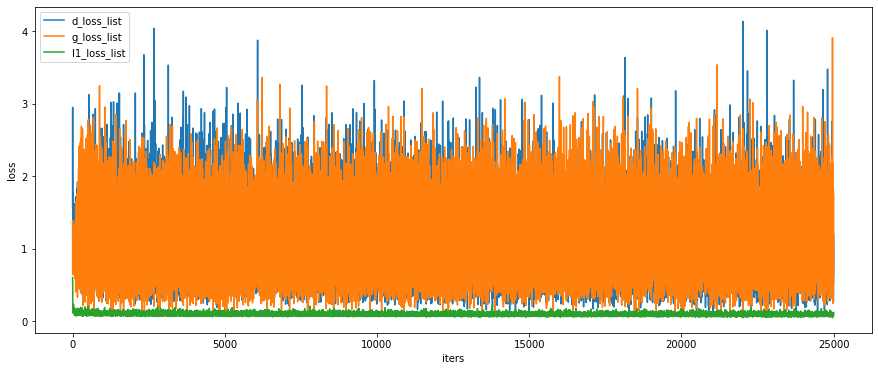

In [34]:
plt.figure(figsize=(15,6))
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.plot(l1_loss_list)
plt.ylabel('loss')  
plt.xlabel('iters') 
plt.legend(['d_loss_list', 'g_loss_list', 'l1_loss_list'], loc='upper left')
plt.savefig('/content/drive/MyDrive/AIFFEL/EX/16.채색/results_img/third_result_loss.jpeg', format='jpeg')
plt.show()

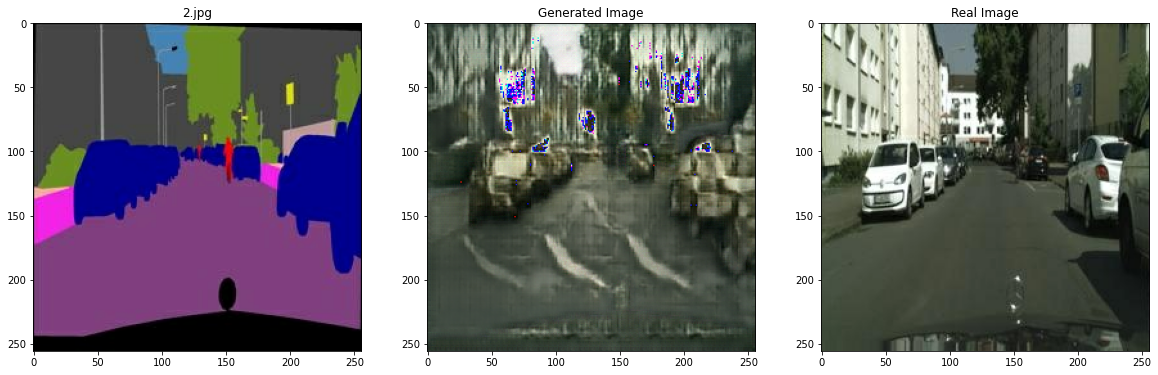

In [38]:
test_ind = 2
test_data_path = '/content/drive/MyDrive/AIFFEL/EX/16.채색/cityscapes/val/'
f = test_data_path + os.listdir(test_data_path)[test_ind]
input_img, real_img = load_img(f)

pred = generator(tf.expand_dims(input_img, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title(f'{os.listdir(test_data_path)[test_ind]}')
plt.imshow(denormalize(input_img))
plt.subplot(1,3,2)
plt.title('Generated Image')
plt.imshow(pred[0])
plt.subplot(1,3,3)
plt.title('Real Image')
plt.imshow(denormalize(real_img))

결과 정리
---

![]('/result_imgs/second_result.jpeg')